In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# 하루

In [2]:
df = pd.read_csv(
    "../input/10min/ontune2016.csv", usecols=["date", "value"], parse_dates=["date"]
)
print(df.shape)
df.head()

(52008, 2)


,date,value
0,2020-03-28 09:00:00,16
1,2020-03-28 09:10:00,9
2,2020-03-28 09:20:00,9
3,2020-03-28 09:30:00,9
4,2020-03-28 09:40:00,9


In [3]:
df.rename(columns={"date": "ds", "value": "y"}, inplace=True)
df.tail()

,ds,y
52003,2021-03-26 08:10:00,12
52004,2021-03-26 08:20:00,12
52005,2021-03-26 08:30:00,12
52006,2021-03-26 08:40:00,13
52007,2021-03-26 08:50:00,12


In [4]:
train = df.iloc[:int(df.shape[0] * 0.8)]
valid = df.iloc[int(df.shape[0] * 0.2):]
valid["days"] = valid["ds"].dt.date
valid = valid.groupby("days")["y"].agg("mean")

In [9]:
def objective(trial: Trial) -> float:
    params = {
        "epochs": trial.suggest_categorical("epochs", [50, 100, 300, 500]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        "num_hidden_layers": trial.suggest_int("num_hidden_layers", 0, 5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "changepoints_range": trial.suggest_discrete_uniform(
            "changepoints_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "seasonality_mode": "additive",
        "yearly_seasonality": False,
        "weekly_seasonality": True,
        "daily_seasonality": True,
        "loss_func": "MSE",
    }
    # fit_model
    m = NeuralProphet(**params)
    m.fit(train, freq="1D")
    future = m.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)

    forecast = m.predict(future)
    valid_forecast = forecast[forecast.y.isna()]
    val_rmse = mean_squared_error(valid_forecast.yhat1, valid, squared=False)

    return val_rmse

In [10]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)

[I 2021-05-17 09:48:34,392] A new study created in memory with name: no-name-83552c30-4de6-44ed-ad5a-17309ebc6920
Epoch[100/100]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s, MSELoss=0.0753, MAE=3.07, RegLoss=0]
[I 2021-05-17 09:49:25,568] Trial 0 finished with value: 24.234019558881663 and parameters: {'epochs': 100, 'batch_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.07109918520180851, 'changepoints_range': 0.803, 'n_changepoints': 35}. Best is trial 0 with value: 24.234019558881663.
Epoch[50/50]: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s, MSELoss=0.0785, MAE=3.1, RegLoss=0] 
[I 2021-05-17 09:50:09,604] Trial 1 finished with value: 32.099178004380335 and parameters: {'epochs': 50, 'batch_size': 64, 'num_hidden_layers': 3, 'learning_rate': 0.01480989220455214, 'changepoints_range': 0.8440000000000001, 'n_changepoints': 25}. Best is trial 0 with value: 24.234019558881663.
Epoch[100/100]: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s, MSELoss=0.075, MAE=2.99, RegL

Epoch[500/500]: 100%|██████████| 500/500 [05:11<00:00,  1.60it/s, MSELoss=0.075, MAE=3.02, RegLoss=0] 
[I 2021-05-17 11:01:56,958] Trial 17 finished with value: 35.88732040944408 and parameters: {'epochs': 500, 'batch_size': 128, 'num_hidden_layers': 2, 'learning_rate': 0.04575609779442446, 'changepoints_range': 0.925, 'n_changepoints': 35}. Best is trial 13 with value: 10.157666326379037.
Epoch[500/500]: 100%|██████████| 500/500 [05:10<00:00,  1.61it/s, MSELoss=0.0747, MAE=3.01, RegLoss=0]
[I 2021-05-17 11:07:08,143] Trial 18 finished with value: 41.621303716595 and parameters: {'epochs': 500, 'batch_size': 128, 'num_hidden_layers': 1, 'learning_rate': 0.07757136182231539, 'changepoints_range': 0.897, 'n_changepoints': 34}. Best is trial 13 with value: 10.157666326379037.
Epoch[500/500]: 100%|██████████| 500/500 [07:06<00:00,  1.17it/s, MSELoss=0.0784, MAE=3.12, RegLoss=0]
[I 2021-05-17 11:14:15,146] Trial 19 finished with value: 27.68863260891098 and parameters: {'epochs': 500, 'batc

In [11]:
prophet_params = study.best_params
prophet_params["batch_size"] = 64
prophet_params["seasonality_mode"] = "additive"
prophet_params["loss_func"] = "MSE"
prophet_params["weekly_seasonality"] = True
prophet_params["daily_seasonality"] = True
prophet_params["yearly_seasonality"] = False

In [12]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(train, freq="1D")
future = model.make_future_dataframe(train, periods=len(valid), n_historic_predictions=True)
forecast = model.predict(future)

Epoch[500/500]: 100%|██████████| 500/500 [07:20<00:00,  1.14it/s, MSELoss=0.0768, MAE=3.02, RegLoss=0]


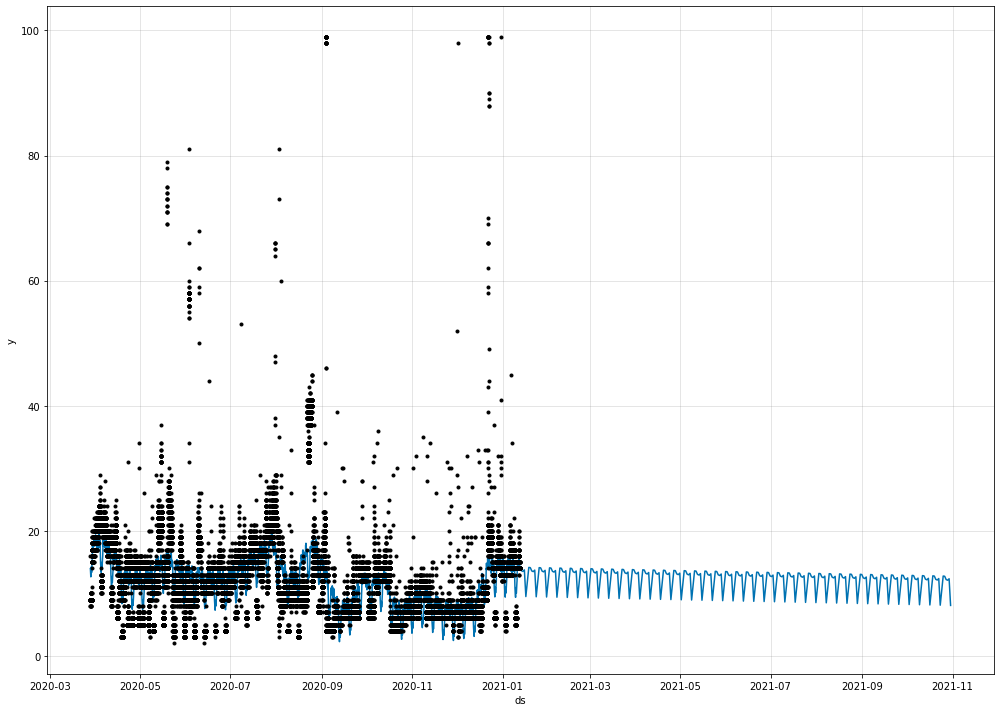

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()

In [14]:
# model = NeuralProphet() if you're using default variables below.
model = NeuralProphet(**prophet_params)
metrics = model.fit(df, freq="1D")
future = model.make_future_dataframe(df, periods=144, n_historic_predictions=True)
forecast = model.predict(future)

Epoch[500/500]: 100%|██████████| 500/500 [10:43<00:00,  1.29s/it, MSELoss=0.161, MAE=4.59, RegLoss=0]


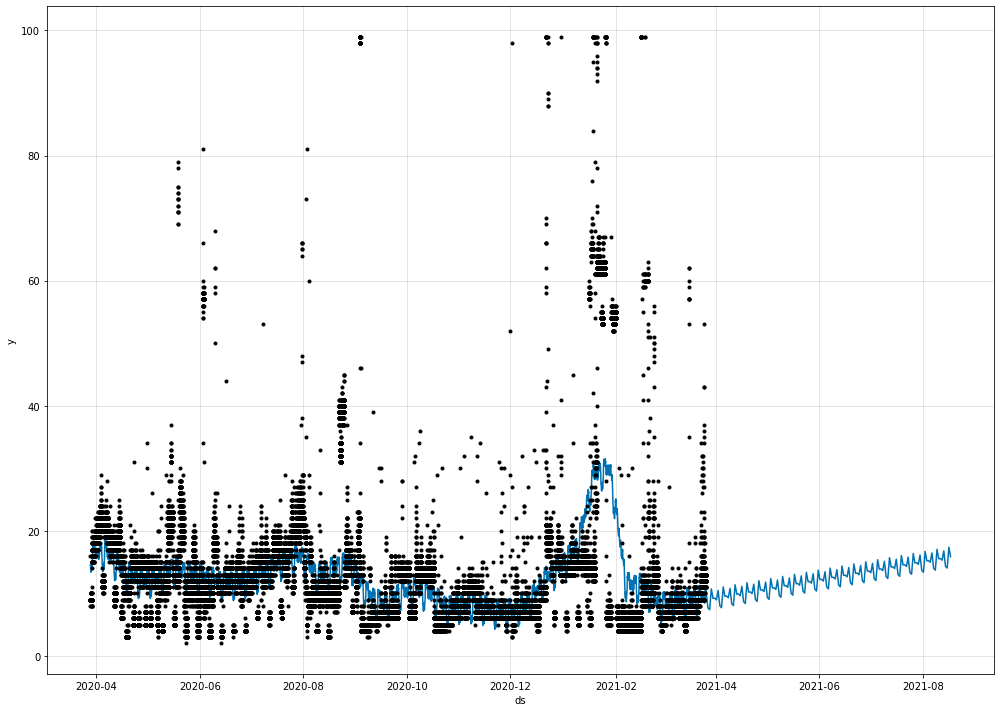

In [15]:
fig, ax = plt.subplots(figsize=(14, 10))
model.plot(forecast, ax=ax)
plt.show()